In [1]:
import pandas as pd
import numpy as np


In [2]:
# Set your project path
base_path = "C:/Users/Administrator/clinical-nlp-projects/clinical-nlp-qa-pipeline/"

# Load the annotations
human_df = pd.read_csv(base_path + "human_annotations.csv")
machine_df = pd.read_csv(base_path + "machine_annotations.csv")

# Preview the data
print("Human Annotations:")
display(human_df)

print("Machine Annotations:")
display(machine_df)


Human Annotations:


,text,start,end,label
0,Aspirin,0,7,DRUG
1,500 mg,8,14,DOSAGE
2,headache,22,30,CONDITION


Machine Annotations:


,text,start,end,label
0,Aspirin,0,7,DRUG
1,500 mg,8,14,STRENGTH
2,migraine,22,30,CONDITION


In [3]:
def preprocess(df, source):
    df = df.copy()
    df["label"] = df["label"].str.upper().str.strip()
    df["text"] = df["text"].str.strip()
    df["source"] = source
    df["entity_id"] = df["start"].astype(str) + "_" + df["end"].astype(str) + "_" + df["label"]
    return df

human_df = preprocess(human_df, "human")
machine_df = preprocess(machine_df, "machine")


In [4]:
print("Preprocessed Human Annotations:")
display(human_df)

print("Preprocessed Machine Annotations:")
display(machine_df)


Preprocessed Human Annotations:


,text,start,end,label,source,entity_id
0,Aspirin,0,7,DRUG,human,0_7_DRUG
1,500 mg,8,14,DOSAGE,human,8_14_DOSAGE
2,headache,22,30,CONDITION,human,22_30_CONDITION


Preprocessed Machine Annotations:


,text,start,end,label,source,entity_id
0,Aspirin,0,7,DRUG,machine,0_7_DRUG
1,500 mg,8,14,STRENGTH,machine,8_14_STRENGTH
2,migraine,22,30,CONDITION,machine,22_30_CONDITION


In [5]:
# Combine both human and machine annotations
all_annotations = pd.concat([human_df, machine_df], ignore_index=True)

# Group by span (start, end)
grouped = all_annotations.groupby(["start", "end"])


In [6]:
qa_results = []

for (start, end), group in grouped:
    labels = group["label"].tolist()
    sources = group["source"].tolist()
    texts = group["text"].tolist()

    # Exact Match
    if "human" in sources and "machine" in sources and labels[0] == labels[1]:
        match_type = "True Positive"
        error_type = None

    # Partial Match (same span, different label)
    elif "human" in sources and "machine" in sources and labels[0] != labels[1]:
        match_type = "Partial Match"
        error_type = "Label Mismatch"

    # False Negative (only human)
    elif "human" in sources and "machine" not in sources:
        match_type = "False Negative"
        error_type = "Missed by Machine"

    # False Positive (only machine)
    elif "machine" in sources and "human" not in sources:
        match_type = "False Positive"
        error_type = "Spurious Prediction"

    else:
        match_type = "Other"
        error_type = "Unknown Case"

    # Store QA info
    qa_results.append({
        "start": start,
        "end": end,
        "text": texts[0],
        "human_label": group[group.source == "human"]["label"].values[0] if "human" in sources else None,
        "machine_label": group[group.source == "machine"]["label"].values[0] if "machine" in sources else None,
        "match_type": match_type,
        "error_type": error_type
    })

# Convert to DataFrame
qa_df = pd.DataFrame(qa_results)


In [7]:
# Show final QA comparison table
display(qa_df)


,start,end,text,human_label,machine_label,match_type,error_type
0,0,7,Aspirin,DRUG,DRUG,True Positive,None
1,8,14,500 mg,DOSAGE,STRENGTH,Partial Match,Label Mismatch
2,22,30,headache,CONDITION,CONDITION,True Positive,None


In [8]:
# Count match types
match_counts = qa_df["match_type"].value_counts()
print("Match Type Counts:\n", match_counts)

# Count errors
error_counts = qa_df["error_type"].value_counts(dropna=False)
print("\nError Types:\n", error_counts)


Match Type Counts:
 match_type
True Positive    2
Partial Match    1
Name: count, dtype: int64

Error Types:
 error_type
None              2
Label Mismatch    1
Name: count, dtype: int64


In [9]:
TP = (qa_df["match_type"] == "True Positive").sum()
FP = (qa_df["match_type"] == "False Positive").sum()
FN = (qa_df["match_type"] == "False Negative").sum()
Partial = (qa_df["match_type"] == "Partial Match").sum()

# Metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"Partial Matches: {Partial}")


Precision: 1.00
Recall:    1.00
F1 Score:  1.00
Partial Matches: 1


In [10]:
qa_df.to_csv(base_path + "qa_report.csv", index=False)
print("QA report saved to qa_report.csv ✅")


QA report saved to qa_report.csv ✅


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set(style="whitegrid")


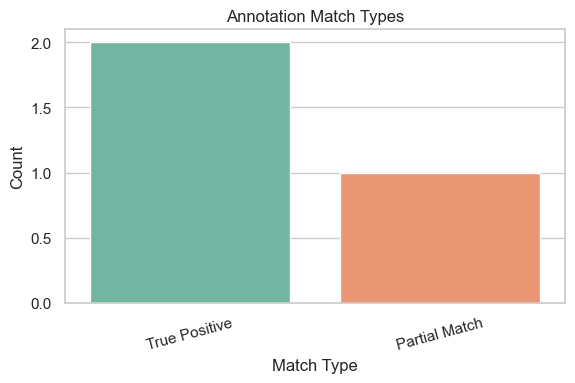

In [13]:
# Bar plot of match types (future-proofed)
plt.figure(figsize=(6, 4))
sns.countplot(data=qa_df, x="match_type", hue="match_type", palette="Set2", legend=False)
plt.title("Annotation Match Types")
plt.xlabel("Match Type")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


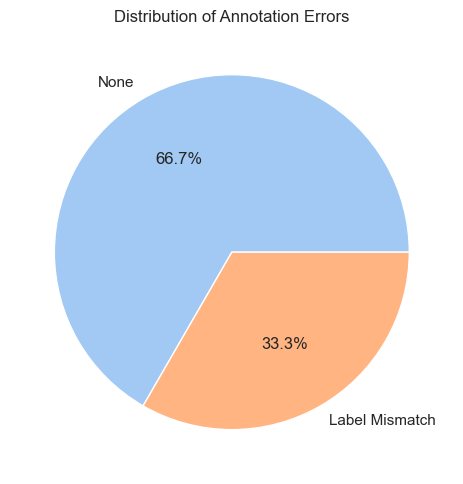

In [14]:
# Fill NaN with 'None' for plotting
qa_df["error_type_filled"] = qa_df["error_type"].fillna("None")

# Pie chart
error_counts = qa_df["error_type_filled"].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(error_counts, labels=error_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Distribution of Annotation Errors")
plt.tight_layout()
plt.show()


Charts saved to PNG ✅


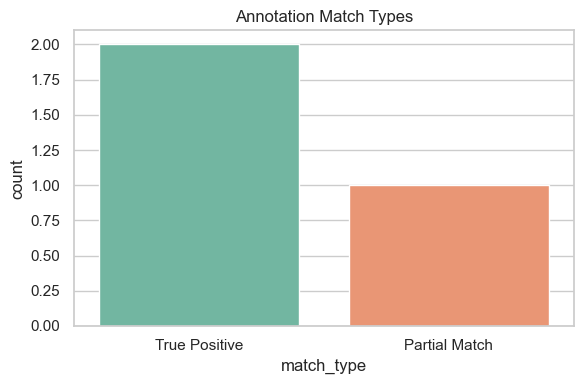

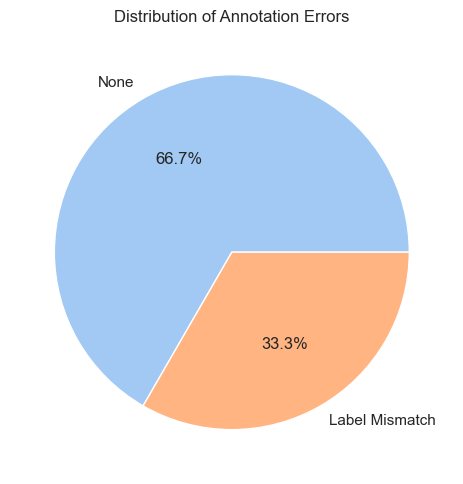

In [16]:
# ✅ Save bar chart (no warning)
plt.figure(figsize=(6, 4))
sns.countplot(data=qa_df, x="match_type", hue="match_type", palette="Set2", legend=False)
plt.title("Annotation Match Types")
plt.tight_layout()
plt.savefig(base_path + "match_type_bar_chart.png")

# ✅ Save pie chart
error_counts = qa_df["error_type"].fillna("None").value_counts()

plt.figure(figsize=(5, 5))
plt.pie(error_counts, labels=error_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Distribution of Annotation Errors")
plt.tight_layout()
plt.savefig(base_path + "error_type_pie_chart.png")

print("Charts saved to PNG ✅")
